# Language_Detection

Celem projektu jest automatyczne rozpoznawanie języka tekstu na podstawie krótkich próbek. Model został wytrenowany na zbiorze danych zawierającym teksty w 17 językach, z wykorzystaniem technik NLP (TF-IDF) i algorytmu klasyfikacyjnego.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## Wczytywanie danych

In [4]:
data = pd.read_csv("..\input\Language Detection.csv")

In [5]:
data.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [6]:
data.isnull().sum()

Text        0
Language    0
dtype: int64

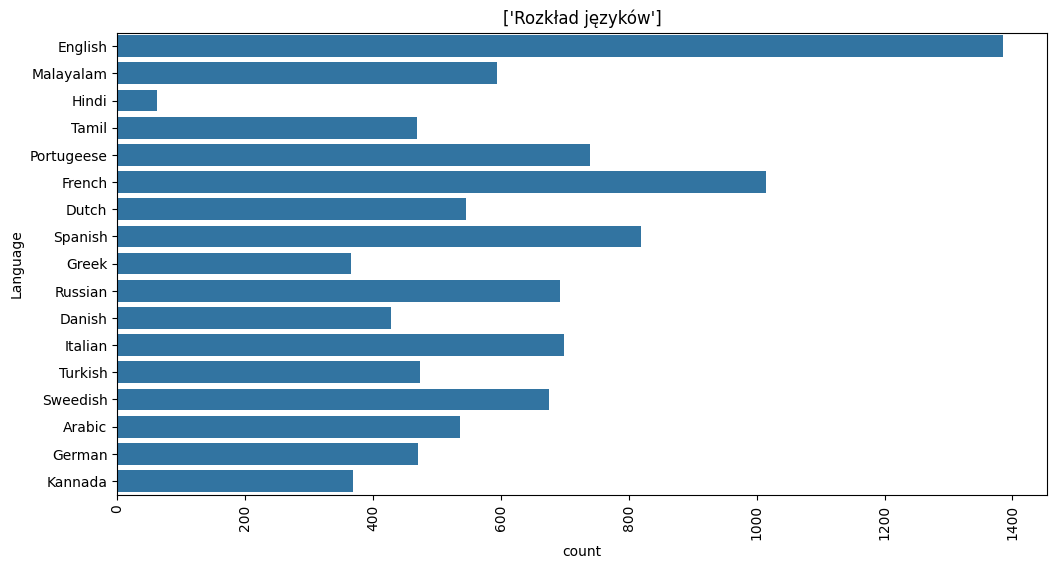

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(data['Language'])
plt.title(['Rozkład języków'])
plt.xticks(rotation= 90)
plt.show()

In [8]:
data['Language'].value_counts()

Language
English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: count, dtype: int64

## Preprocessing

In [10]:
def clean_text(text):
    text = re.sub(r'[!@#$(),\n"%^*?\:;~`0-9]', ' ', text) # zastepuje wszystkie wymienione znaki spacja
    text = re.sub(r'[\[\]]', ' ', text) # zastepuje nawiasy kwadratowe spacją
    return text.lower()

In [11]:
data["Text"] = data["Text"].apply(clean_text)

In [12]:
data.sample(10)

,Text,Language
10021,ನಾನು ನಿಮಗೆ ಆ ರಹಸ್ಯ ಸಲಹೆಯನ್ನು ತುಂಬಾ ನಿರರ್ಗಳವಾಗಿ...,Kannada
3056,eu não me importo se alguém está perguntando a...,Portugeese
4736,heb even geduld met mij.,Dutch
6703,oprindeligt var det udelukkende en engelskspro...,Danish
8003,ne yaptın hayatında neler oluyor diye soruyor...,Turkish
4014,je n'écoutais pas parce que tu étais peut-être...,French
150,the biosphere is the part of earth's outer she...,English
3904,dans certains cas les biais algorithmiques pe...,French
8588,modellen använde dock rätt trubbiga mått på ak...,Sweedish
3673,un wiki est un site web dynamique dont les vi...,French


## Rozdzielenie danych

In [14]:
X = data["Text"]
y = data["Language"]

## Zamiana zmiennych kategorialnych na numeryczne

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## Walidacja danych

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

## Torby słów

TfidfVectorizer służy do konwersji danych teskowych na cechy numeryczne które bierze pod uwage:
- Unigramy (pojedyncze słowa, np. "Harry", "Potter")
- Bigramy (pary słów, np. "Harry Potter", "Potter i")


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [21]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)
x_train = tfidf.transform(X_train).toarray()
x_test = tfidf.transform(X_test).toarray()


In [22]:
print(x_train.shape)
print(x_test.shape)


(8269, 139505)
(2068, 139505)


## Budowanie modelu 

Model którego uzyje to klasyfikator bayesowski, a konkretnie jego wariant dla cech dyskretnych – Multinomial Naive Bayes (MultinomialNB).
MultinomialNB wykorzystuje twierdzenie Bayesa z założeniem (tzw. "naive" – naiwnym) o niezależności cech. Model ten jest szczególnie przydatny przy danych, gdzie cechy mają charakter dyskretny, np. liczby wystąpień słów w dokumentach.
Jest często wykorzystywany do zadań takich jak filtrowanie spamu, analiza sentymentu czy kategoryzacja dokumentów.

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [26]:
model = MultinomialNB()
params = {'alpha':[0.01,0.1,0.5,1]}


In [27]:
grid_search = GridSearchCV(model, param_grid= params, cv=5, scoring= 'accuracy')

In [28]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.1, 0.5, 1]}, scoring='accuracy')

In [29]:
best_model = grid_search.best_estimator_

In [30]:
results = pd.DataFrame(grid_search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.832985,1.053900,0.313043,0.026098,0.01,{'alpha': 0.01},0.979444,0.977025,0.981258,0.977025,0.980641,0.979079,0.001775,1
1,3.350456,0.141882,0.386521,0.043783,0.10,{'alpha': 0.1},0.977025,0.977025,0.975816,0.972793,0.975802,0.975692,0.001548,2
2,3.294275,0.032605,0.342717,0.023618,0.50,{'alpha': 0.5},0.943773,0.949214,0.939541,0.939541,0.938899,0.942193,0.003917,3
3,3.120263,0.046689,0.293218,0.002776,1.00,{'alpha': 1},0.891173,0.902056,0.889964,0.894196,0.892922,0.894062,0.004251,4


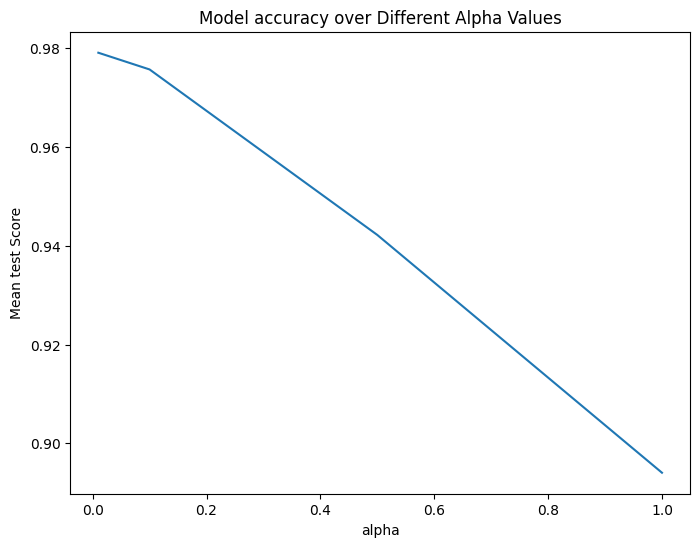

In [31]:
plt.figure(figsize=(8,6))
sns.lineplot(x='param_alpha', y= 'mean_test_score', data=results)
plt.title('Model accuracy over Different Alpha Values')
plt.xlabel('alpha')
plt.ylabel('Mean test Score')
plt.show()

Wartościach alfa wizualizacja dokładności modelu na róznych wartościach hiperparametru alpha w celu zidentyfikowania optymalnej wartosci

In [34]:
y_pred = best_model.predict(x_test)

## Ocena modelu 

In [35]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate classification report
class_report = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9743713733075435
Confusion Matrix:
[[ 99   0   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  72   0   0   0   1   0   0   0   0   0   0   0   0   2   0   0]
 [  0   0 109   3   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 283   0   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   2 191   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   3   0  94   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0  78   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  13   0   0   0   0   0   0   0   0   0]
 [  0   0   0   2   0   0   0   0 125   0   0   0   0   1   0   0   0]
 [  0   0   0   4   0   0   0   0   0  82   0   0   0   0   0   0   0]
 [  0   0   0   5   0   0   0   0   0   0 111   0   0   0   0   0   0]
 [  0   0   0   1   1   0   0   0   0   0   0 126   0   3   0   0   0]
 [  0   0   0   4   0   0   0   0   0   0   0   0 137   1   0   0   0]
 [  0   0   0   2   0   0   0 

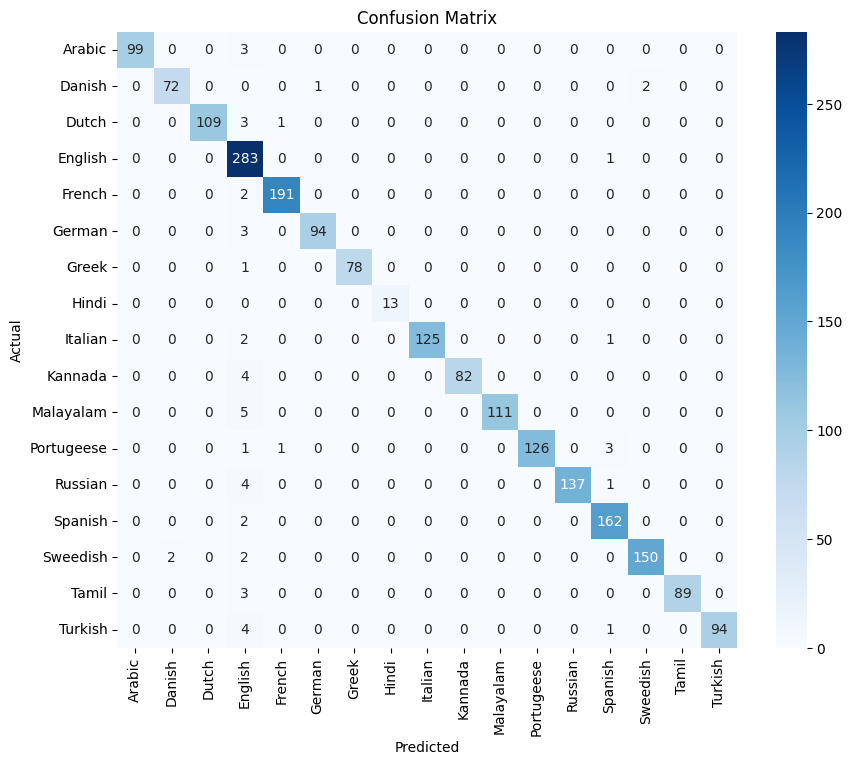

In [36]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot= True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model Deployment

### Tworzenie Potoku

In [38]:
from sklearn.pipeline import Pipeline

In [67]:
pipeline = Pipeline([
    ('vectorizer', tfidf),
    ('multinomialNB', best_model)
])
pipeline.fit(X_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('multinomialNB', MultinomialNB(alpha=0.01))])

Potok ten obejmuje wektoryzator tfidf i najlepszy model multinomialNB dopasują sie do potoku na danych treningowych.
Potok łączy preprocessing (TF-IDF) i model w jeden obiekt, co upraszcza kod i eliminuje ryzyko błędów.

## Zapisywanie modelu 

In [77]:
with open('..\model\Pipeline_and_model_Language_Detection-0.1.0.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

# TEST MODELU

In [106]:
text = 'Hello'
y= pipeline.predict([text])
print(le.classes_[y[0]])

English


In [98]:
text = 'Hallo'
y= pipeline.predict([text])
print(le.classes_[y[0]])

Dutch


In [104]:
text = 'Как вы' # jak sie masz
y= pipeline.predict([text])
print(le.classes_[y[0]])

Russian


In [102]:
text = 'Como vai' # jak sie masz
y= pipeline.predict([text])
print(le.classes_[y[0]])

Portugeese
